In [11]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.inference import Inference
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(20, grid_bounds=[(0, 1), (0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
prior_model = KissGPModel()

In [12]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.numpy()
    
    test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Observed Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Observed - Actual')
    
    return f

In [5]:
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Optimize the model
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(60):
    optimizer.zero_grad()
    output = posterior_model(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = posterior_model.eval()

/Users/ruihanwu/playground/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/60 - Loss: 1726.734
Iter 2/60 - Loss: 1656.411
Iter 3/60 - Loss: 1581.444
Iter 4/60 - Loss: 1508.945
Iter 5/60 - Loss: 1426.214
Iter 6/60 - Loss: 1350.754
Iter 7/60 - Loss: 1277.088
Iter 8/60 - Loss: 1189.768
Iter 9/60 - Loss: 1092.231
Iter 10/60 - Loss: 995.143
Iter 11/60 - Loss: 887.202
Iter 12/60 - Loss: 774.910
Iter 13/60 - Loss: 670.986
Iter 14/60 - Loss: 553.868
Iter 15/60 - Loss: 449.509
Iter 16/60 - Loss: 353.329
Iter 17/60 - Loss: 271.588
Iter 18/60 - Loss: 180.162
Iter 19/60 - Loss: 100.081
Iter 20/60 - Loss: 6.165
Iter 21/60 - Loss: -67.785
Iter 22/60 - Loss: -151.254
Iter 23/60 - Loss: -229.985
Iter 24/60 - Loss: -302.830
Iter 25/60 - Loss: -389.332
Iter 26/60 - Loss: -475.465
Iter 27/60 - Loss: -550.604
Iter 28/60 - Loss: -636.606
Iter 29/60 - Loss: -723.944
Iter 30/60 - Loss: -789.884
Iter 31/60 - Loss: -875.847
Iter 32/60 - Loss: -937.685
Iter 33/60 - Loss: -1028.053
Iter 34/60 - Loss: -1093.351
Iter 35/60 - Loss: -1158.789
Iter 36/60 - Loss: -1260.899
Iter 37/60 

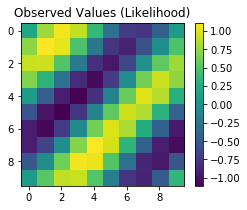

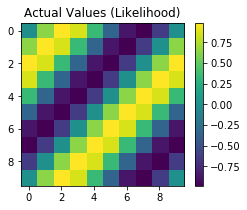

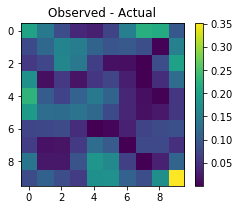

In [13]:
f = plot_model_and_predictions(posterior_model)